#  Nettoyage des données

## Chargement des librairies et des données

In [98]:
import pandas as pd
from datetime import datetime
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

customers = pd.read_csv('customers.csv')
products = pd.read_csv('products.csv')
transactions = pd.read_csv('transactions.csv')



## Extraction des produits invendus et des clients n'ayant jamais commandé

In [99]:
prod_trans_ids = transactions['id_prod'].unique()
unsold_prod = products[~products['id_prod'].isin(prod_trans_ids)]
cust_trans_ids = transactions['client_id'].unique()
inactive_cust = customers[~customers['client_id'].isin(cust_trans_ids)]
products = products[products['id_prod'].isin(prod_trans_ids)]
customers = customers[customers['client_id'].isin(cust_trans_ids)]

In [167]:
unsold_prod.to_csv('produits_invendus.csv')
print("Produits invendus :")
unsold_prod


Produits invendus :


,id_prod,price,categ
184,0_1016,35.06,0
279,0_1780,1.67,0
737,0_1062,20.08,0
794,0_1119,2.99,0
811,0_1014,1.15,0
846,1_0,31.82,1
1031,0_1318,20.92,0
1139,0_1800,22.05,0
1347,0_1645,2.99,0
1505,0_322,2.99,0


In [168]:
inactive_cust.to_csv('clients_inactifs.csv')
print("Clients n'ayant jamais commandé :")
inactive_cust


Clients n'ayant jamais commandé :


,client_id,sex,birth
801,c_8253,f,2001
2483,c_3789,f,1997
2734,c_4406,f,1998
2769,c_2706,f,1967
2851,c_3443,m,1959
3179,c_4447,m,1956
3190,c_3017,f,1992
3334,c_4086,f,1992
3721,c_6930,m,2004
3821,c_4358,m,1999


## Suppression des doublons et des valeurs manquantes

### Définition fonctions nettoyage

In [103]:
def clean_df(df):
    doublons = df.duplicated().sum()
    print(f"Il y a {doublons} doublons dans le DataFrame.")
    df = df.drop_duplicates()
    na_nb = df.isnull().sum()
    print(f"Il y a {na_nb} NA dans le DataFrame.")
    
    return df

### Nettoyage des données clients

In [104]:
customers=clean_df(customers)

Il y a 0 doublons dans le DataFrame.
Il y a client_id    0
sex          0
birth        0
dtype: int64 NA dans le DataFrame.


### Nettoyage des données produits

In [105]:
products=clean_df(products)

Il y a 0 doublons dans le DataFrame.
Il y a id_prod    0
price      0
categ      0
dtype: int64 NA dans le DataFrame.


### Nettoyage des données transactions

In [106]:
transactions=clean_df(transactions)

Il y a 126 doublons dans le DataFrame.
Il y a id_prod       0
date          0
session_id    0
client_id     0
dtype: int64 NA dans le DataFrame.


In [107]:
duplicates = transactions[transactions.duplicated(keep=False)]
duplicates

,id_prod,date,session_id,client_id


In [108]:
unique_sessions_in_duplicates = duplicates['session_id'].nunique()
unique_sessions_in_duplicates

0

<div class="alert alert-block alert-warning"> <b> Les doublons sont supprimés ici car ils proviennent d'une seule session qui utilise des valeurs test </b> </div>

In [109]:
transactions = transactions.drop_duplicates()

<b>Reformatage des dates</b> 

In [110]:
transactions['date'] = transactions['date'].astype(str)
transactions = transactions[~transactions['date'].str.contains('test_')]
transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')
transactions.dropna(subset=['date'], inplace=True)
transactions.reset_index(drop=True, inplace=True)

# Consolidation des données

## Jointure des dataframes

In [111]:
merged_data = pd.merge(customers, transactions, on='client_id', how='left')
df_final= pd.merge(merged_data, products, on='id_prod', how='left')

##  Produit sans prix

In [112]:
na_prices_count = df_final['price'].isnull().sum()
print(na_prices_count)

105


<div class="alert alert-block alert-warning">Il y a 126 transactions avec un produit sans prix</div>

In [113]:
unique_product_ids_with_na_price = df_final[df_final['price'].isnull()]['id_prod'].unique()
print(unique_product_ids_with_na_price)

['0_2245' nan]


<div class="alert alert-block alert-warning">L'id du produit est 0_2245. On va lui donner la catégorie 0 et un prix égal au prix moyen de tous les produits. </div>

In [114]:
mean_price = products['price'].mean()
df_final.loc[df_final['id_prod'] == '0_2245', 'categ'] = 0.0
df_final.loc[df_final['id_prod'] == '0_2245', 'price'] = mean_price
df_final[df_final['id_prod'] == '0_2245']
df_stats_tmp=df_final

## Ajout de l'age

In [115]:
current_year = datetime.now().year
df_final['age'] = current_year - df_final['birth']
df_final = df_final.drop(columns='birth')

## Fréquence de commande

In [116]:
df_final['nb_com'] = df_final.groupby('client_id')['session_id'].transform('nunique')
#suppression des clients qui n'ont pas commandé
df_final = df_final[df_final['nb_com'] > 0]
#conversion de la catégorie en string
df_final['categ'] = df_final['categ'].astype(str).str[0]



## Total des achats par client et moyenne

In [117]:
df_final.loc[:, 'tot_ach'] = df_final.groupby('client_id')['price'].transform('sum')
df_final.loc[:, 'moy_ach'] = (df_final['tot_ach'] / df_final['nb_com']).round(2)



In [118]:
df_final

,client_id,sex,id_prod,date,session_id,price,categ,age,nb_com,tot_ach,moy_ach
0,c_4410,f,0_1455,2021-03-22 14:29:25.189266,s_9942,8.99,0,57,25,575.20,23.01
1,c_4410,f,0_1376,2021-09-24 22:58:27.418343,s_94984,16.24,0,57,25,575.20,23.01
2,c_4410,f,1_312,2022-01-29 14:07:47.482092,s_156960,24.56,1,57,25,575.20,23.01
3,c_4410,f,1_653,2021-07-29 23:34:41.866951,s_68860,25.99,1,57,25,575.20,23.01
4,c_4410,f,0_1110,2021-11-04 16:28:30.169021,s_114715,4.71,0,57,25,575.20,23.01
...,...,...,...,...,...,...,...,...,...,...,...
336813,c_84,f,1_459,2022-02-17 00:16:56.629536,s_166337,15.99,1,42,8,313.03,39.13
336814,c_84,f,0_1050,2021-09-20 10:05:37.086910,s_92701,12.51,0,42,8,313.03,39.13
336815,c_84,f,0_1417,2021-03-13 23:55:06.835238,s_5960,17.99,0,42,8,313.03,39.13
336816,c_84,f,1_343,2021-04-13 03:59:33.614841,s_19845,27.99,1,42,8,313.03,39.13


## Articles par commande et cumulé

In [119]:
df_final.loc[:, 'tot_art'] = df_final.groupby('client_id')['id_prod'].transform('count')
df_final.loc[:, 'moy_art_com'] = df_final['tot_art'] / df_final['nb_com'].round(2)

In [120]:
df_final['date'] = pd.to_datetime(df_final['date'])
latest_date_df = df_final.groupby('client_id')['date'].max().reset_index()
df_final_latest = pd.merge(df_final, latest_date_df, on=['client_id', 'date'], how='inner')
today = datetime.now()
df_final_latest['recency'] = (today - df_final['date']).dt.days
df_final_latest.drop(columns=['date'], inplace=True)
category_data = df_final.groupby(['client_id', 'categ']).agg(
    nb_cat=('session_id', 'nunique'),
    tot_cat=('price', 'sum')
).unstack(level=-1, fill_value=0)
category_data.columns = ['_'.join(map(str, col)).strip() for col in category_data.columns.values]
df_final = df_final_latest.merge(category_data, on='client_id', how='left')
df_final = df_final.round(2)
cols_to_drop = ['id_prod', 'session_id', 'price','categ','session_id']
df_final.drop(columns=cols_to_drop, inplace=True)
df_final


,client_id,sex,age,nb_com,tot_ach,moy_ach,tot_art,moy_art_com,recency,nb_cat_0,nb_cat_1,nb_cat_2,tot_cat_0,tot_cat_1,tot_cat_2
0,c_4410,f,57,25,575.20,23.01,36,1.44,1091,15,14,0,227.79,347.41,0.00
1,c_7839,f,49,9,276.05,30.67,18,2.00,905,6,5,0,102.47,173.58,0.00
2,c_1699,f,40,3,99.49,33.16,8,2.67,778,3,1,0,80.41,19.08,0.00
3,c_5961,f,62,27,545.73,20.21,35,1.30,962,14,14,0,198.07,347.66,0.00
4,c_5320,m,81,9,203.47,22.61,12,1.33,864,6,5,0,77.05,126.42,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8595,c_7920,m,68,21,727.38,34.64,40,1.90,775,11,14,0,201.44,525.94,0.00
8596,c_7403,f,54,54,1189.34,22.02,74,1.37,783,22,39,0,264.09,925.25,0.00
8597,c_5119,m,50,10,335.72,33.57,20,2.00,1106,8,2,1,142.62,81.38,111.72
8598,c_5643,f,56,53,1068.11,20.15,70,1.32,1027,27,31,0,276.56,791.55,0.00


# Statistiques et Corrélations

## Dataframe sans le top 4

<div class="alert alert-block alert-warning">En raison du poids extrêment important des 4 plus gros clients, il est impératif de faire des analyse sans ces derniers</div>

In [121]:
# Identifier les 4 plus gros clients basé sur la colonne 'tot_ach'
top_4_clients = df_final.groupby('client_id')['tot_ach'].sum().nlargest(4).index

# Créer un nouveau DataFrame sans les 4 plus gros clients
df_sans_top4 = df_final[~df_final['client_id'].isin(top_4_clients)]


## Corrélation âge et fréquence d'achat

### Tous les clients

<div class="alert alert-block alert-warning"> On pose H0 : Il n'y a pas de corrélation significative entre l'âge des clients et leur fréquence d'achat avec un risque alpha de 0.05. </div>

In [156]:
#  la corrélation entre l'âge et la fréquence d'achat
correlation, p_valeur = pearsonr(df_final['age'],df_final['nb_com'])
print(f"La corrélation entre l'âge et la fréquence d'achat est : {correlation} ")
print(f'la p-valeur est de {p_valeur}')

La corrélation entre l'âge et la fréquence d'achat est : 0.034487677265775875 
la p-valeur est de 0.0013802853290307351


<div class="alert alert-block alert-success">La p_value est supérieure au risque alpha 0.05, on ne peut pas rejeter l'hypothèse nulle.
Il n'y a pas de preuve statistique significative d'une relation entre l'âge des clients et la fréquence de leurs achats.  L'âge ne semble pas être un bon prédicteur de la fréquence d'achat dans ce contexte.</div>

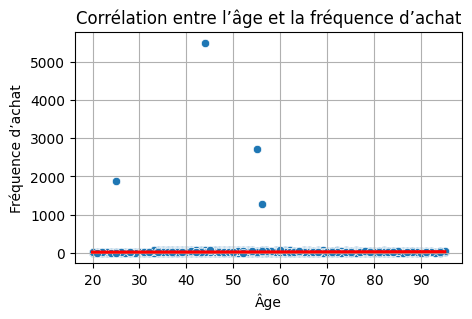

In [162]:
plt.figure(figsize=(5, 3))
sns.scatterplot(x='age', y='nb_com', data=df_final)
sns.regplot(x='age', y='nb_com', data=df_final, scatter=False, color='red')
plt.title('Corrélation entre l’âge et la fréquence d’achat')
plt.xlabel('Âge')
plt.ylabel('Fréquence d’achat')
plt.grid(True)
plt.show()

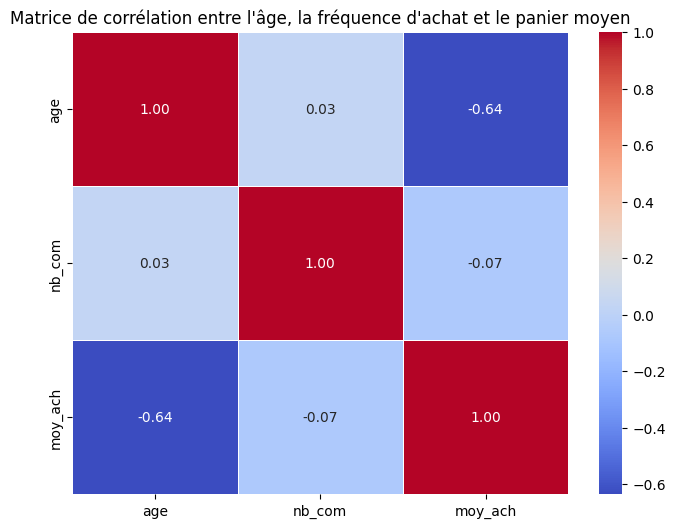

In [163]:
df_age_freq_moy = df_final[['age', 'nb_com', 'moy_ach']]
corr_age_freq_moy = df_age_freq_moy.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_age_freq_moy, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de corrélation entre l\'âge, la fréquence d\'achat et le panier moyen')
plt.show()


### Sans le top 4

<div class="alert alert-block alert-warning"> On pose H0 : Il n'y a pas de corrélation significative entre l'âge des clients et leur fréquence d'achat avec un risque alpha de 0.05. </div>

In [124]:
# la corrélation entre l'âge et la fréquence d'achat
correlation, p_valeur = pearsonr(df_sans_top4['age'],df_sans_top4['tot_art'])
print(f"La corrélation entre l'âge et la fréquence d'achat est : {correlation} ")
print(f'la p-valeur est de {p_valeur}')

La corrélation entre l'âge et la fréquence d'achat est : 0.03004242568238165 
la p-valeur est de 0.0053429482937534046


<div class="alert alert-block alert-success">On rejette H0 .
    
    
  La p-valeur inférieure au seuil de signification suggère que la corrélation observée n'est pas due au hasard, mais qu'il existe une association réelle entre l'âge et la fréquence d'achat.
    
  La corrélation positive indique que, en général, à mesure que l'âge des clients augmente, leur fréquence d'achat a tendance à augmenter légèrement.
</div>

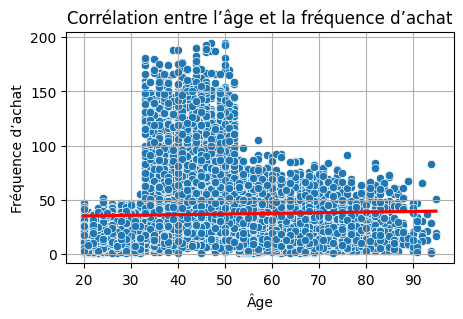

In [125]:
plt.figure(figsize=(5, 3))
sns.scatterplot(x='age', y='tot_art', data=df_sans_top4)
sns.regplot(x='age', y='tot_art', data=df_sans_top4, scatter=False, color='red')
plt.title('Corrélation entre l’âge et la fréquence d’achat')
plt.xlabel('Âge')
plt.ylabel('Fréquence d’achat')
plt.grid(True)
plt.show()

## Corrélation entre âge et montant d'achat par catégorie

### Pour tous les clients 

In [126]:
# Liste des colonnes représentant les totaux par catégorie
categorie_columns = ['tot_cat_0', 'tot_cat_1', 'tot_cat_2']

# Calculer la corrélation entre l'âge et le montant dépensé pour chaque catégorie
correlation_results = {}
for categorie_column in categorie_columns:
    correlation, p_value = pearsonr(df_final['age'], df_final[categorie_column])
    categorie = categorie_column.split('_')[-1]  # Récupérer le numéro de catégorie à partir du nom de colonne
    correlation_results[categorie] = (correlation, p_value)

# Afficher les résultats
for categorie, (correlation, p_value) in correlation_results.items():
    print(f"Catégorie {categorie}:")
    print(f"Corrélation: {correlation}")
    print(f"P-valeur: {p_value}")
    print()

Catégorie 0:
Corrélation: 0.0018828115016212281
P-valeur: 0.8614100341878373

Catégorie 1:
Corrélation: 0.07173213010447145
P-valeur: 2.7424322386775716e-11

Catégorie 2:
Corrélation: -0.1185980329443881
P-valeur: 2.570511186345923e-28



<div class="alert alert-block alert-success">
<li> <b>Catégorie 0</b> :  Une corrélation très faible et non significative entre l'âge des clients et le montant dépensé dans la catégorie 0. La p-valeur élevée suggère que cette corrélation pourrait être due au hasard. </li>
    
<li><b>Catégorie 1</b>: Corrélation modérée et significative entre l'âge des clients et le montant dépensé dans la catégorie 1 </li>
    
<li><b>Catégorie 2</b>: Corrélation modérée et significative entre l'âge des clients et le montant dépensé dans la catégorie 2.</li>

</div>

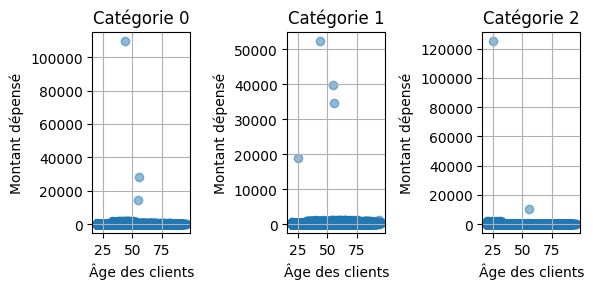

In [127]:
plt.figure(figsize=(6, 3))

categorie_columns = ['tot_cat_0', 'tot_cat_1', 'tot_cat_2']
for i, categorie_column in enumerate(categorie_columns, 1):
    plt.subplot(1, 3, i)
    plt.scatter(df_final['age'], df_final[categorie_column], alpha=0.5)
    plt.title(f'Catégorie {i-1}')
    plt.xlabel('Âge des clients')
    plt.ylabel('Montant dépensé')
    plt.grid(True)

plt.tight_layout()
plt.show()

### Sans le top 4

In [128]:
categorie_columns = ['tot_cat_0', 'tot_cat_1', 'tot_cat_2']
correlation_results = {}
for categorie_column in categorie_columns:
    correlation, p_value = pearsonr(df_sans_top4['age'], df_sans_top4[categorie_column])
    categorie = categorie_column.split('_')[-1]  # Récupérer le numéro de catégorie à partir du nom de colonne
    correlation_results[categorie] = (correlation, p_value)

for categorie, (correlation, p_value) in correlation_results.items():
    print(f"Catégorie {categorie}:")
    print(f"Corrélation: {correlation}")
    print(f"P-valeur: {p_value}")
    print()

Catégorie 0:
Corrélation: 0.002672193134789517
P-valeur: 0.804354327266716

Catégorie 1:
Corrélation: 0.29310067248782856
P-valeur: 6.932716101001323e-170

Catégorie 2:
Corrélation: -0.5191293276517748
P-valeur: 0.0



<div class="alert alert-block alert-success">
<li> <b>Catégorie 0</b> : Corrélation très faible et non significative, peut-être due au hasard </li>
    
<li><b>Catégorie 1</b>: Corrélation modérée et significative </li>
    
<li><b>Catégorie 2</b>:  Forte corrélation négative et significative entre l'âge des clients et le montant dépensé dans la catégorie 2.</li>

</div>

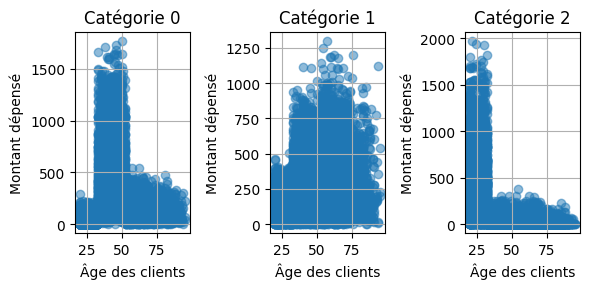

In [129]:
plt.figure(figsize=(6, 3))

categorie_columns = ['tot_cat_0', 'tot_cat_1', 'tot_cat_2']
for i, categorie_column in enumerate(categorie_columns, 1):
    plt.subplot(1, 3, i)
    plt.scatter(df_sans_top4['age'], df_sans_top4[categorie_column], alpha=0.5)
    plt.title(f'Catégorie {i-1}')
    plt.xlabel('Âge des clients')
    plt.ylabel('Montant dépensé')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Corrélation entre genre du client et montant dépensé par catégorie 

### Tous les clients 

In [130]:

df_female = df_final[df_final['sex'] == 'f']
df_male = df_final[df_final['sex'] == 'm']

#  le test ANOVA pour chaque catégorie
anova_results = {}
for category in ['tot_cat_0', 'tot_cat_1', 'tot_cat_2']:
    category_values_female = df_female[category]
    category_values_male = df_male[category]
    f_statistic, p_value = f_oneway(category_values_female, category_values_male)
    anova_results[category] = (f_statistic, p_value)

# Afficher les résultats
for category, (f_statistic, p_value) in anova_results.items():
    print(f"Catégorie {category}:")
    print(f"Statistique F : {f_statistic}")
    print(f"P-valeur : {p_value}")
    if p_value < 0.05:
        print("Il y a une différence significative dans les montants dépensés entre les genres.")
    else:
        print("Il n'y a pas de différence significative dans les montants dépensés entre les genres.")
    print()


Catégorie tot_cat_0:
Statistique F : 0.9725786487986386
P-valeur : 0.324065662990913
Il n'y a pas de différence significative dans les montants dépensés entre les genres.

Catégorie tot_cat_1:
Statistique F : 0.6917411262079745
P-valeur : 0.40559588746636466
Il n'y a pas de différence significative dans les montants dépensés entre les genres.

Catégorie tot_cat_2:
Statistique F : 1.1744189883647438
P-valeur : 0.2785255023385704
Il n'y a pas de différence significative dans les montants dépensés entre les genres.



### Sans le top 4

In [164]:

# Séparer les données par genre
df_f = df_sans_top4[df_sans_top4['sex'] == 'f']
df_h = df_sans_top4[df_sans_top4['sex'] == 'm']

# Effectuer le test ANOVA pour chaque catégorie
anova_results = {}
for category in ['tot_cat_0', 'tot_cat_1', 'tot_cat_2']:
    category_values_female = df_f[category]
    category_values_male = df_h[category]
    f_statistic, p_value = f_oneway(category_values_female, category_values_male)
    anova_results[category] = (f_statistic, p_value)

# Afficher les résultats
for category, (f_statistic, p_value) in anova_results.items():
    print(f"Catégorie {category}:")
    print(f"Statistique F : {f_statistic}")
    print(f"P-valeur : {p_value}")
    if p_value < 0.05:
        print("Il y a une différence significative dans les montants dépensés entre les genres.")
    else:
        print("Il n'y a pas de différence significative dans les montants dépensés entre les genres.")
    print()


Catégorie tot_cat_0:
Statistique F : 0.25625375463735955
P-valeur : 0.6127186220334746
Il n'y a pas de différence significative dans les montants dépensés entre les genres.

Catégorie tot_cat_1:
Statistique F : 0.7975168356546155
P-valeur : 0.37186183896567204
Il n'y a pas de différence significative dans les montants dépensés entre les genres.

Catégorie tot_cat_2:
Statistique F : 0.46990854042575286
P-valeur : 0.4930477370610834
Il n'y a pas de différence significative dans les montants dépensés entre les genres.



## Visualisation de données 

In [132]:
df_stats_tmp['categ'] = df_stats_tmp['categ'].astype(str).str[0]



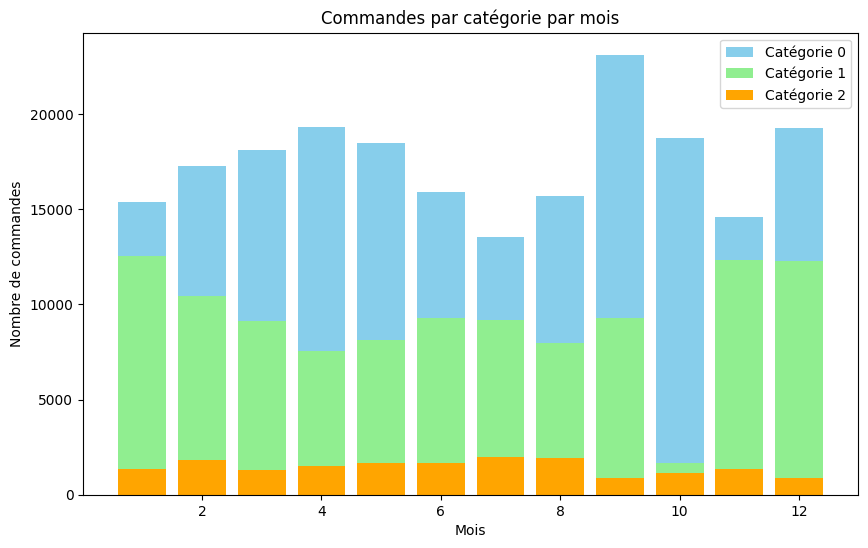

In [133]:


# Convertir la colonne "date" en format datetime
df_stats_tmp['date'] = pd.to_datetime(df_stats_tmp['date'])
import pandas as pd
import matplotlib.pyplot as plt

# Convertir la colonne "date" en format datetime
df_stats_tmp['date'] = pd.to_datetime(df_stats_tmp['date'])

df_stats_tmp['month'] = df_stats_tmp['date'].dt.month
df_stats_tmp['year'] = df_stats_tmp['date'].dt.year
monthly_orders = df_stats_tmp.groupby(['year', 'month', 'categ']).size().reset_index(name='order_count')
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['skyblue', 'lightgreen', 'orange']
for i, category in enumerate(monthly_orders['categ'].unique()):
    category_data = monthly_orders[monthly_orders['categ'] == category]
    ax.bar(category_data['month'], category_data['order_count'], label=f'Catégorie {category}', color=colors[i])
ax.set_title('Commandes par catégorie par mois')
ax.set_xlabel('Mois')
ax.set_ylabel('Nombre de commandes')
ax.legend()
plt.show()


/tmp/ipykernel_8963/3067326424.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  october_data['day'] = october_data['date'].dt.day
/tmp/ipykernel_8963/3067326424.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  october_data['month'] = october_data['date'].dt.month
/tmp/ipykernel_8963/3067326424.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

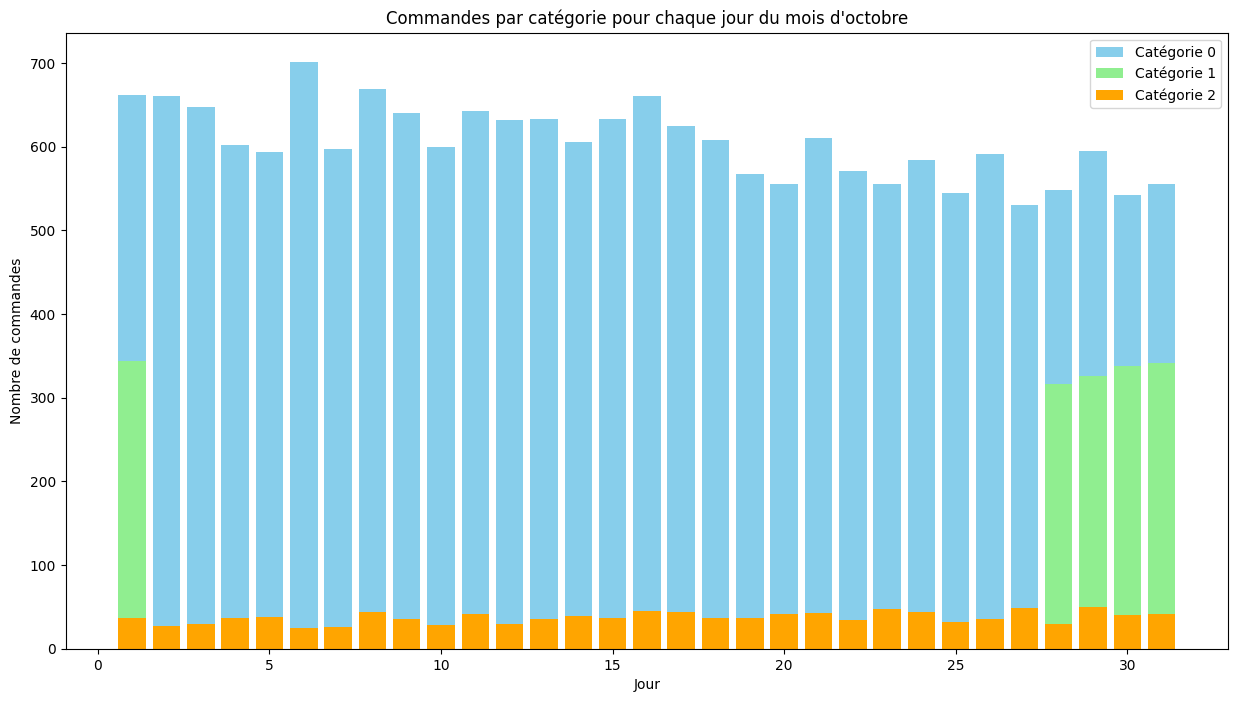

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir la colonne "date" en format datetime
df_stats_tmp['date'] = pd.to_datetime(df_stats_tmp['date'])

october_data = df_stats_tmp[df_stats_tmp['date'].dt.month == 10]
october_data['day'] = october_data['date'].dt.day
october_data['month'] = october_data['date'].dt.month
october_data['year'] = october_data['date'].dt.year
daily_orders = october_data.groupby(['year', 'month', 'day', 'categ']).size().reset_index(name='order_count')
custom_colors = {'0': 'skyblue', '1': 'lightgreen', '2': 'orange'}
fig, ax = plt.subplots(figsize=(15, 8))

for category in daily_orders['categ'].unique():
    category_data = daily_orders[daily_orders['categ'] == category]
    ax.bar(category_data['day'], category_data['order_count'], label=f'Catégorie {category}', color=custom_colors[str(category)])

ax.set_title('Commandes par catégorie pour chaque jour du mois d\'octobre')
ax.set_xlabel('Jour')
ax.set_ylabel('Nombre de commandes')
ax.legend()
plt.show()



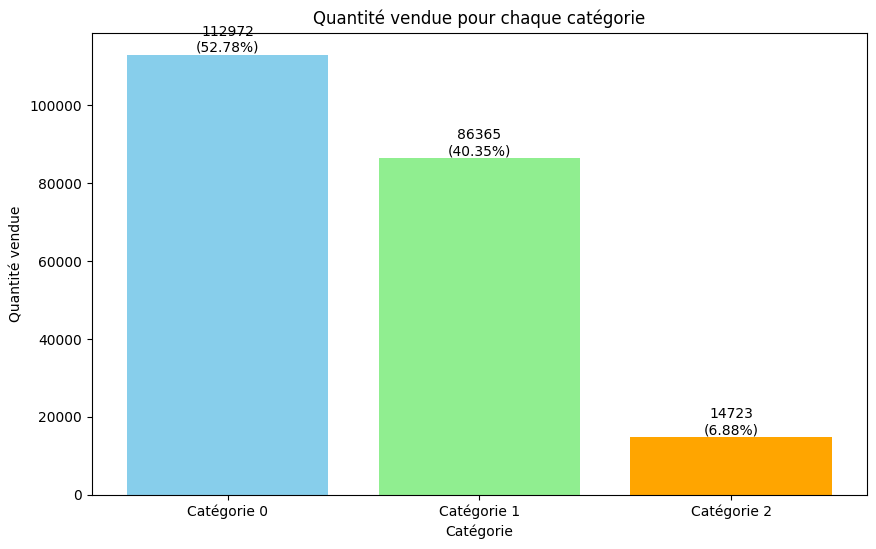

In [141]:

categories = ['Catégorie 0', 'Catégorie 1', 'Catégorie 2']
quantites = [df_final['nb_cat_0'].sum(), df_final['nb_cat_1'].sum(), df_final['nb_cat_2'].sum()]
total_quantites = sum(quantites)

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, quantites, color=['skyblue', 'lightgreen', 'orange'])
plt.xlabel('Catégorie')
plt.ylabel('Quantité vendue')
plt.title('Quantité vendue pour chaque catégorie')

for bar, quantite in zip(bars, quantites):
    percentage = (quantite / total_quantites) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{quantite}\n({percentage:.2f}%)', ha='center', va='bottom')

plt.show()

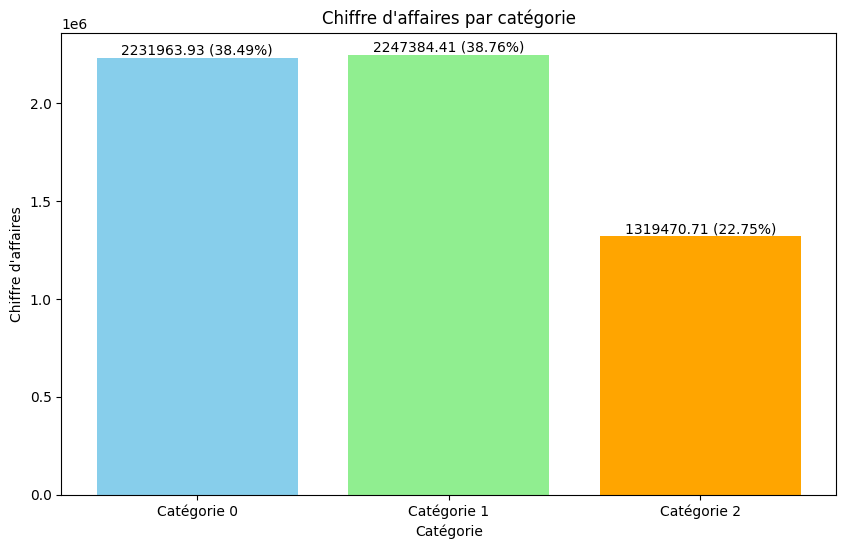

In [140]:
categories = ['Catégorie 0', 'Catégorie 1', 'Catégorie 2']
chiffre_affaires = [df_final['tot_cat_0'].sum(), df_final['tot_cat_1'].sum(), df_final['tot_cat_2'].sum()]
total_chiffre_affaires = sum(chiffre_affaires)

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, chiffre_affaires, color=['skyblue', 'lightgreen', 'orange'])
plt.xlabel('Catégorie')
plt.ylabel('Chiffre d\'affaires')
plt.title('Chiffre d\'affaires par catégorie')

for bar, chiffre in zip(bars, chiffre_affaires):
    percentage = (chiffre / total_chiffre_affaires) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{chiffre:.2f} ({percentage:.2f}%)', ha='center', va='bottom')
plt.show()



### Analyse de la clientèle

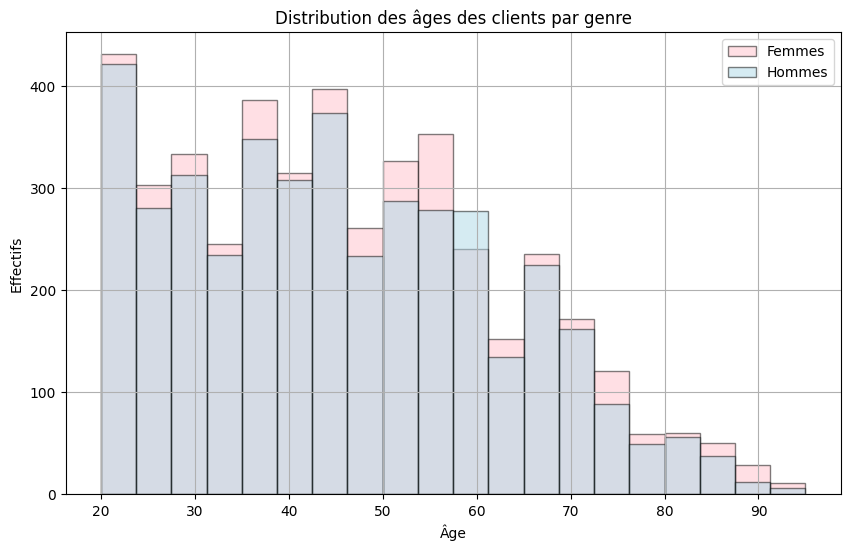

In [161]:
df_female = df_final[df_final['sex'] == 'f']
df_male = df_final[df_final['sex'] == 'm']
plt.figure(figsize=(10, 6))
# Plot de l'histogramme pour les femmes
plt.hist(df_female['age'], bins=20, color='pink', edgecolor='black', alpha=0.5, label='Femmes')
# Plot de l'histogramme pour les hommes
plt.hist(df_male['age'], bins=20, color='lightblue', edgecolor='black', alpha=0.5, label='Hommes')
plt.xlabel('Âge')
plt.ylabel('Effectifs')
plt.title('Distribution des âges des clients par genre')
plt.legend()
plt.grid(True)
plt.show()

### Comportements d'achats

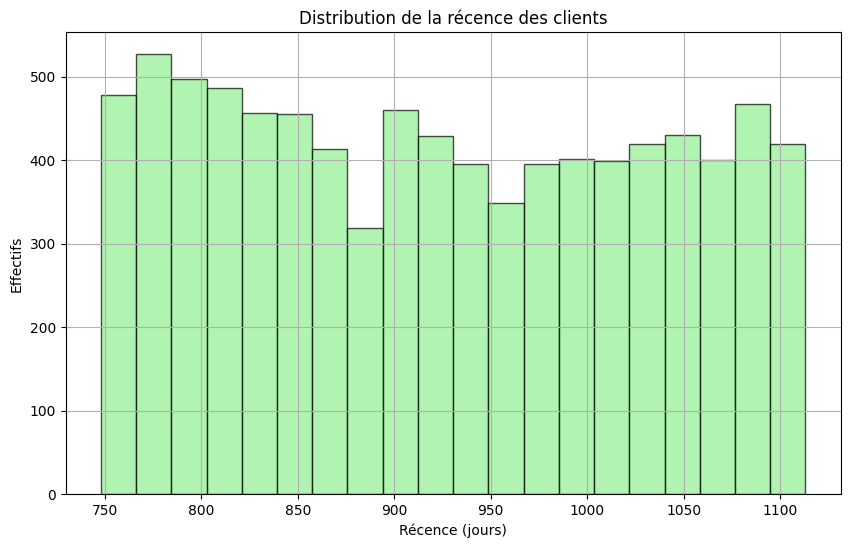

In [144]:
plt.figure(figsize=(10, 6))
plt.hist(df_final['recency'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
plt.xlabel('Récence (jours)')
plt.ylabel('Effectifs')
plt.title('Distribution de la récence des clients')
plt.grid(True)
plt.show()


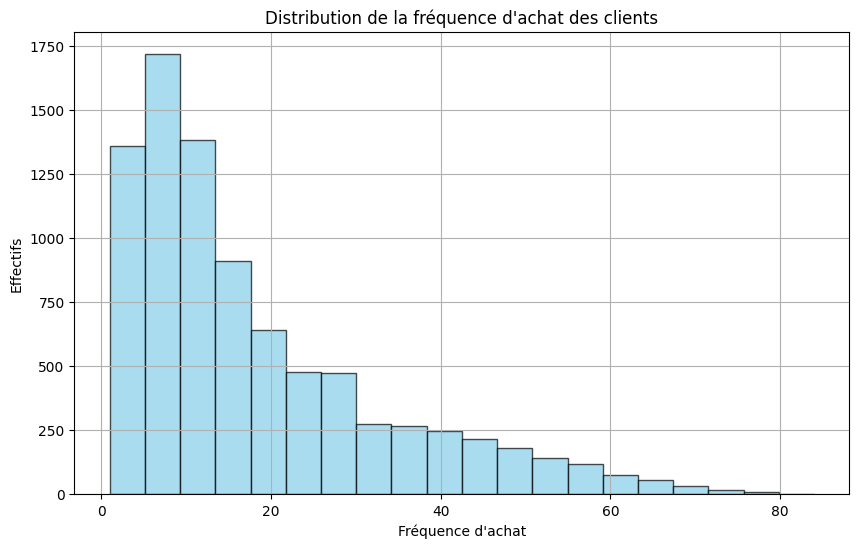

In [146]:
plt.figure(figsize=(10, 6))
plt.hist(df_sans_top4['nb_com'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Fréquence d\'achat')
plt.ylabel('Effectifs')
plt.title('Distribution de la fréquence d\'achat des clients sans le top 4')
plt.grid(True)
plt.show()


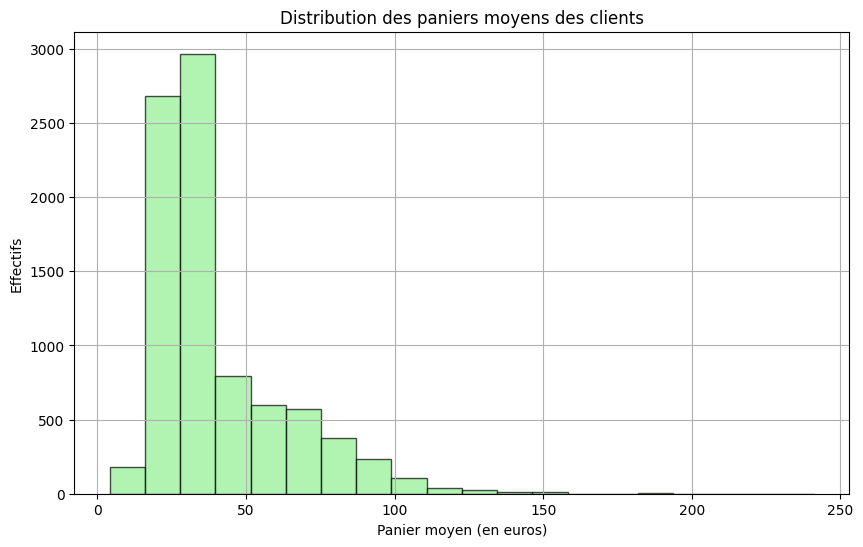

In [148]:
plt.figure(figsize=(10, 6))
plt.hist(df_sans_top4['moy_ach'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
plt.xlabel('Panier moyen (en euros)')
plt.ylabel('Effectifs')
plt.title('Distribution des paniers moyens des clients')
plt.grid(True)
plt.show()


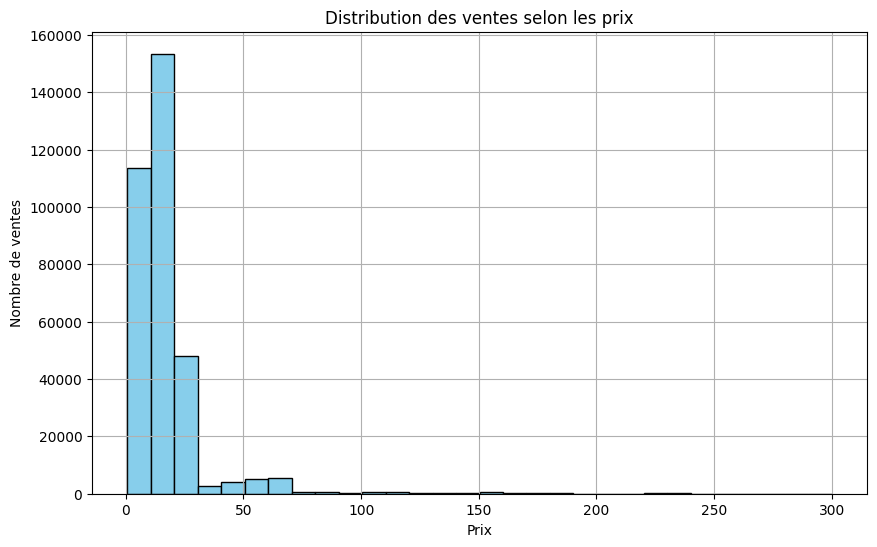

In [152]:
plt.figure(figsize=(10, 6))
plt.hist(df_stats_tmp['price'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Prix')
plt.ylabel('Nombre de ventes')
plt.title('Distribution des ventes selon les prix')
plt.grid(True)
plt.show()